<a href="https://colab.research.google.com/github/Jan-Piotraschke/fachkurs_systembiology/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [84]:
# !pip3 install scipy pandas numpy matplotlib
# !pip3 install voila  # Voilà works with any Jupyter kernel (C++, Python, Julia)
from scipy.integrate import odeint
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import ipywidgets as widgets  # make this notebook interactive


? Warum Gbg Daten und nicht Ga

In [85]:
data_wet_5A = pd.read_csv('data/Fig-5-A-data.csv')
data_wet_5A.set_index('Unnamed: 0', drop=True, inplace=True)

data_wet_5B = pd.read_csv('data/Fig-5-B-data.csv')
display(data_wet_5A)
display(data_wet_5B)

,time,alphaF,Gbg_mean,Gbg_std
Unnamed: 0,,,,
0,10,1000,0.3504,0.0080
1,30,1000,0.4000,0.0040
2,60,1000,0.3680,0.0120
3,120,1000,0.3868,0.0148
4,210,1000,0.3304,0.0160
5,300,1000,0.2420,0.0320
6,450,1000,0.1748,0.0240
7,600,1000,0.1948,0.0160


,time,alphaF,Gbg_mean,Gbg_std
0,60,1,0.060,0.008
1,60,2,0.108,0.020
2,60,5,0.200,0.028
3,60,10,0.304,0.024
4,60,20,0.400,0.012
5,60,50,0.408,0.004
6,60,100,0.412,0.012


In [86]:
# parameters
k_RL = 2 * 10 ** 6
k_RLm = 10 ** -2
k_Rs = 4
k_Rd0 = 4 * 4 ** -4
k_Rd1 = k_Rd0 * 10
k_G1 = 1
k_Ga = 10 ** -5

Gt = 10 ** 4  # total number of G proteins per cell



In [87]:
def solve_ode_system(current_state, t, k_Gd, L) -> list:
    """

    :param current_state: current state of the ODE system
    :param t: time of simulation
    :param parameter: rate constant for G protein deactivation
    :return: solution of the ODE System
    """
    R, RL, G, Ga = current_state

    # algebraic equations:
    Gd = Gt - G - Ga  # Galpha-GDP
    Gbg = Gt - G  # free Gbetagamma

    # the ODEs ahead:
    dR_dt = -k_RL*L*R + k_RLm*RL - k_Rd0*R + k_Rs
    dRL_dt = k_RL*L*R - k_RLm*RL - k_Rd1*RL
    dG_dt = -k_Ga*RL*G + k_G1*Gd*Gbg
    dGa_dt = k_Ga*RL*G - k_Gd*Ga

    return [dR_dt, dRL_dt, dG_dt, dGa_dt]



In [88]:
time = np.arange(0, 600, 0.01)

# initial values
# TODO: dummy values -> didn't found the real values yet
R_0 = 5000  # free receptor
RL_0 = 500  # receptor bound to ligand
G_0 = 9000  # inactive heterotrimeric G protein
Ga_0 = 500  # active Galpha-GTP
S0 = [R_0, RL_0, G_0, Ga_0]

# variable rate constant for G protein deactivation
k_Gd = 0.004   # 0.11  # 0.004
L_alpha =  10 ** -6  # alpha-factor -> 1 uM
solution = pd.DataFrame(odeint(solve_ode_system, S0, time, args=(k_Gd, L_alpha)), columns=['R', 'RL', 'G', 'Ga'], index=time)

dose_response = {}
for L_var in data_wet_5B.alphaF:  # nM alpha-factor 
    data = pd.DataFrame(odeint(solve_ode_system, S0, time, args=(k_Gd, L_var*10**-3)), columns=['R', 'RL', 'G', 'Ga'], index=time)
    dose_response[L_var] = data.loc[[60.00]].Ga.iloc[0]  # get Ga value for t=60s
    # data.plot()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


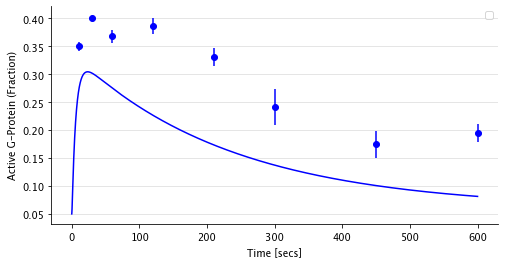

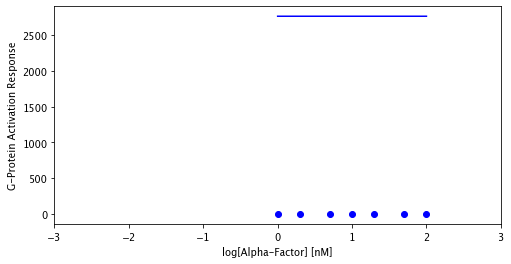

In [109]:
fig, ax = plt.subplots(figsize=(8, 4)) #, ncols=2)

# choose the style of the plot
# print(plt.style.available)
# plt.style.use('classic')
ax.set_xlabel("Time [secs]")
ax.set_ylabel("Active G-Protein (Fraction)")

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# NOTE: maybe not correct yet
ax.plot(time, solution["Ga"]/Gt, color='blue')  # Fig. 5A from the paper 
ax.errorbar(data_wet_5A.time, data_wet_5A.Gbg_mean, fmt='o', yerr=data_wet_5A.Gbg_std, color='blue')  # the wet data 
ax.legend()

# plt.legend(loc=(1.1,0.5), frameon=False)

# ax.xaxis.set_ticks([0,60,120])
# ax.set_xlim(0,200)
# ax.set_ylim(0,5000)
ax.yaxis.grid(alpha=0.4)

# plt.savefig('GA_Deaths_40days.png', dpi=600, bbox_inches='tight')
fig1, ax1 = plt.subplots(figsize=(8, 4)) #, ncols=2)
ax1.set_xlabel('log[Alpha-Factor] [nM]')
ax1.set_ylabel('G-Protein Activation Response')

ax1.plot(np.log10(list(dose_response.keys())), dose_response.values(), color='blue')  # Fig. 5A from the paper 
ax1.errorbar(np.log10(data_wet_5B.alphaF), data_wet_5B.Gbg_mean, fmt='o', yerr=data_wet_5B.Gbg_std, color='blue')  # the wet data 

ax1.set_xlim(-3,3)



plt.show()